Hunter Bennett | Glass Lab | Kupffer Strains Project | April 27 2021  

This series of notebooks is for manuscript preparation of "final" figures for import into Adobe Illustrator.

This notebook in particular prepares the ATAC and H3K27Ac scatter plots as one large figure.

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [3]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [4]:
atacDirectory = '/home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/'
h3k27acDirectory = '/home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/'
workingDirectory = '/home/h1bennet/strains/results/10_Strains_Manuscript_Prep/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Make folder for these figures

In [6]:
if not os.path.isdir('./epigenetic_scatter_figure/'):
    os.mkdir('./epigenetic_scatter_figure/')

# Import strains rna-seq data

In [ ]:
tpm_mat_control = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaQuan/rawT.txt',
                      sep='\t', index_col=0)
tpm_mat = tpm_mat.loc[:, tpm_mat.columns.str.contains('control')]

### Import differential peaks for h3k27ac and atac

In [16]:
atac_diff_peak, atac_peaks, atac_peak_mat, atac_peak_mat_quant = import_homer_diffpeak(
    atacDirectory+'/merged_peaks/diff_output.txt',
    atacDirectory+'/merged_peaks/ann_norm_idr_peaks_merged.txt')

annotatePeaks all peaks (86301, 30)
getDiffExpression selected transcripts (84264, 39)
annotatePeaks selected peaks (84264, 30)


In [17]:
atac_comp_dict = pull_comparisons_get_diff(atac_diff_peak, seq_type='Peak')

In [18]:
h3k27ac_diff_peak, h3k27ac_peaks, h3k27ac_peak_mat, h3k27ac_peak_mat_quant = import_homer_diffpeak(
    h3k27acDirectory+'/merged_peaks/diff_output.txt',
    h3k27acDirectory+'/merged_peaks/ann_norm_kc_control_atac_peaks_all.txt')

annotatePeaks all peaks (86301, 27)
getDiffExpression selected transcripts (84264, 36)
annotatePeaks selected peaks (84264, 27)


In [19]:
h3k27ac_comp_dict = pull_comparisons_get_diff(h3k27ac_diff_peak, seq_type='Peak')

# Set parameters that don't change throughout plotting

In [20]:
comps = ['aj vs. balbcj',
         'aj vs. c57bl6j',
         'balbcj vs. c57bl6j']

labels = [['A/J\nlog2(tag counts + 1)', 'BALB/cJ\nlog2(tag counts + 1)'],
          ['A/J\nlog2(tag counts + 1)', 'C57BL/6J\nlog2(tag counts + 1)'],
          ['BALB/cJ\nlog2(tag counts + 1)', 'C57BL/6J\nlog2(tag counts + 1)']]

h3k27ac_groups = [[[0,1,2],[3,4,5]],
                  [[0,1,2],[6,7,8]],
                  [[3,4,5],[6,7,8]]]

atac_groups = [[[0,1,2,3],[4,5,6,7]],
               [[0,1,2,3],[8,9,10,11]],
               [[4,5,6,7],[8,9,10,11]]]

h3k27ac_cols = []
for i in h3k27ac_groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    h3k27ac_cols.append(subcols)
    
atac_cols = []
for i in atac_groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    atac_cols.append(subcols)

# set plotting thresholds
pthresh = 0.05
lfcthresh = (1,2)
dotsize = 0.5
ax_max = 16
n_yticks = 5
ytickstep = 3
ticklabel_font_size = 6
label_font_size  = 6

In [21]:
colors = [['#636363', '#de2d26'],
          ['#636363', '#de2d26'],
          ['#636363', '#de2d26']]

filename='diffpeak_scatter_onethresh_onecolor_rasterize.pdf'

In [22]:
mm_conv = 25.4

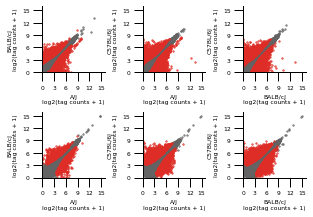

In [33]:
fig, axs = plt.subplots(2,3, figsize=(120/mm_conv,80/mm_conv))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

peak_mat = atac_peak_mat
comp_dict = atac_comp_dict
groups = atac_groups
cols = atac_cols

for key, col, group, labs, color, ax in zip(comps, cols, groups, labels, colors, axs.reshape(-1)[:3]):

    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
       
    # plot group by group scatter:
    de_nonsig = de.reindex(de.index[de.adj_pval >= pthresh])
    de_sig_fc1 = de.reindex(de.index[(de.adj_pval < pthresh) & (np.abs(de.log2fc) >= lfcthresh[0])])
    
    for df, c in zip([de_nonsig, de_sig_fc1],
                     color):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize,
            rasterized=True)
        
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
     
    # set axis labels
    ax.set_xlabel(labs[0], fontsize=label_font_size)
    ax.set_ylabel(labs[1], fontsize=label_font_size)
    
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep), fontsize=ticklabel_font_size)
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep), fontsize=ticklabel_font_size)
    
    
    
peak_mat = h3k27ac_peak_mat
comp_dict = h3k27ac_comp_dict
groups = h3k27ac_groups
cols = h3k27ac_cols

for key, col, group, labs, color, ax in zip(comps, cols, groups, labels, colors, axs.reshape(-1)[3:]):

    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
       
    # plot group by group scatter:
    de_nonsig = de.reindex(de.index[de.adj_pval >= pthresh])
    de_sig_fc1 = de.reindex(de.index[(de.adj_pval < pthresh) & (np.abs(de.log2fc) >= lfcthresh[0])])
    
    for df, c in zip([de_nonsig, de_sig_fc1],
                     color):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize,
            rasterized=True)
        
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
     
    # set axis labels
    ax.set_xlabel(labs[0], fontsize=label_font_size)
    ax.set_ylabel(labs[1], fontsize=label_font_size)
    
    
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep), fontsize=ticklabel_font_size)
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep), fontsize=ticklabel_font_size)
    
    
plt.savefig('./epigenetic_scatter_figure/'+filename, bbox_inches='tight')
# plt.close()